# Required Imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse

# Setup / Data Processing

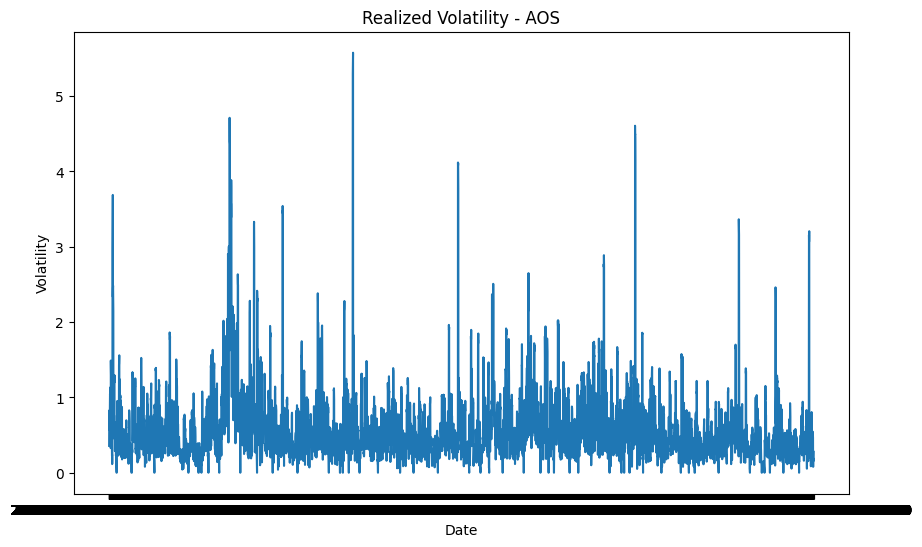

In [ ]:
# Load the CSV data
df = pd.read_csv('Price_data.csv')

# Set the 'time' column as the index
df.set_index('Time', inplace=True)

# Select one stock column (e.g., 'AOS')
stock = df['AOS']

# Calculate returns
ret = 100 * stock.pct_change().dropna()

# Calculate realized volatility (using a 5-period rolling window)
realized_vol = ret.rolling(5).std()

# Plot the realized volatility
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized Volatility - AOS')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [ ]:
n = 252
split_date = ret.iloc[-n:].index

sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(0.27058172472723774, 0.5424953524135693)

In [ ]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks


In [ ]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args=(retv), method='Nelder-Mead', options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

params = opt_params(initial_parameters, retv)



Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1716.4475909124328
             x: [ 4.767e-01  2.824e-01]
           nit: 24
          nfev: 47
 final_simplex: (array([[ 4.767e-01,  2.824e-01],
                       [ 4.767e-01,  2.824e-01],
                       [ 4.767e-01,  2.823e-01]]), array([ 1.716e+03,  1.716e+03,  1.716e+03]))

Resulting params = [0.47665617 0.28240741]


# Volatility Prediction with ARCH


---



The ARCH model (Autoregressive Conditional Heteroskedasticity) was introduced by Robert Engle to model time-varying volatility in financial time series data. In an ARCH model, the current period's volatility is modeled as a function of the past periods' squared errors. This model is useful for capturing the clustering of volatility, a common phenomenon in financial markets where large changes in asset prices tend to be followed by large changes (of either sign), and small changes tend to be followed by small changes. The ARCH model includes parameters for the mean (set to zero in this implementation) and for the autoregressive terms of past squared returns, which influence the current volatility. This model serves as the foundation for more complex models like GARCH, EGARCH, and GJR-GARCH.

The RMSE value of ARCH model is 0.0715


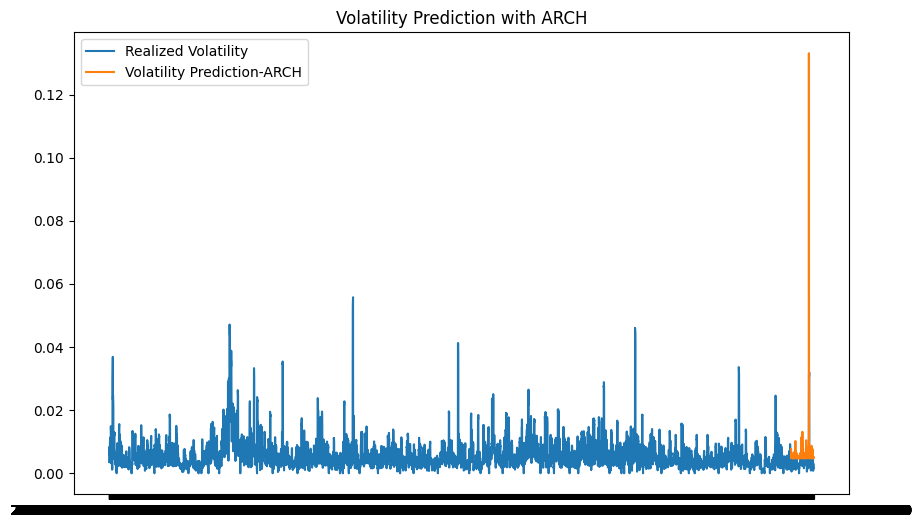

In [ ]:

bic_arch = []

for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p

arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=2001)
forecast_arch = forecast

rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()


# Volatility Prediction with GARCH

---

The GARCH model (Generalized Autoregressive Conditional Heteroskedasticity) is a widely used approach to model time-varying volatility in financial time series. The model accounts for the clustering of volatility, where periods of high volatility are followed by high volatility and periods of low volatility follow low volatility. The GARCH model includes parameters for the mean (set to zero in this context) and for the volatility dynamics through lagged variance and lagged squared returns. This approach allows for a more flexible modeling of conditional variance, capturing the persistence in volatility observed in financial data.


C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmi

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    AOS   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7446.09
Distribution:                  Normal   AIC:                           14908.2
Method:            Maximum Likelihood   BIC:                           14963.9
                                        No. Observations:                 7835
Date:                Wed, Jun 05 2024   Df Residuals:                     7835
Time:                        15:40:48   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.1549e-04  7.400e-04      0.561      0.574 

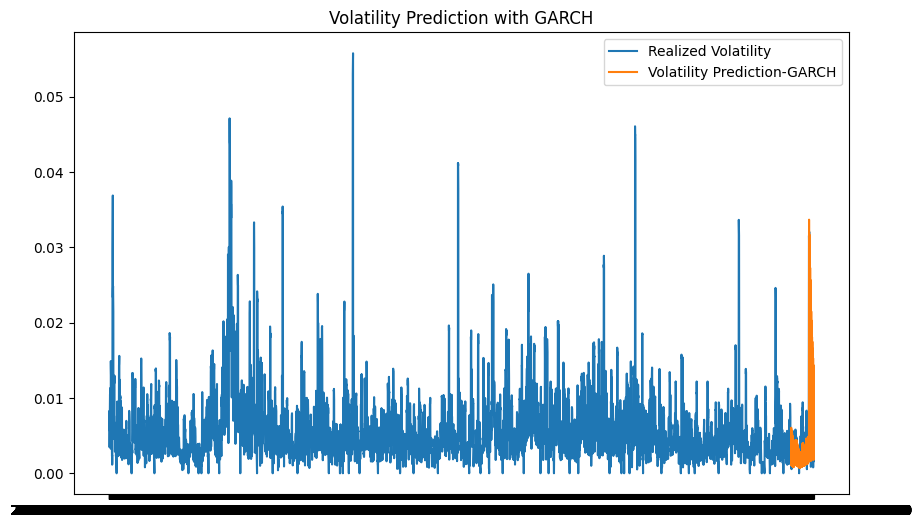

In [ ]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q

garch = arch_model(ret, mean='zero', vol='GARCH', p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())

forecast = garch.forecast(start=2001)
forecast_garch = forecast

rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()


# Volatility Prediction with GJR-GARCH



---

The GJR-GARCH model (Glosten-Jagannathan-Runkle Generalized Autoregressive Conditional Heteroskedasticity) is an extension of the GARCH model that allows for the asymmetric effect of positive and negative shocks on volatility. In this model, volatility increases more with negative shocks than with positive shocks of the same magnitude. This is particularly useful in financial time series where the leverage effect is present. The model includes parameters to capture the mean (set to zero in this case), the GARCH terms (volatility persistence), and the leverage effect.



C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmi

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                    AOS   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7422.34
Distribution:                  Normal   AIC:                           14860.7
Method:            Maximum Likelihood   BIC:                           14916.4
                                        No. Observations:                 7835
Date:                Wed, Jun 05 2024   Df Residuals:                     7835
Time:                        15:43:09   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.3564e-04  4.987e-04      1.676  9.383e-02 

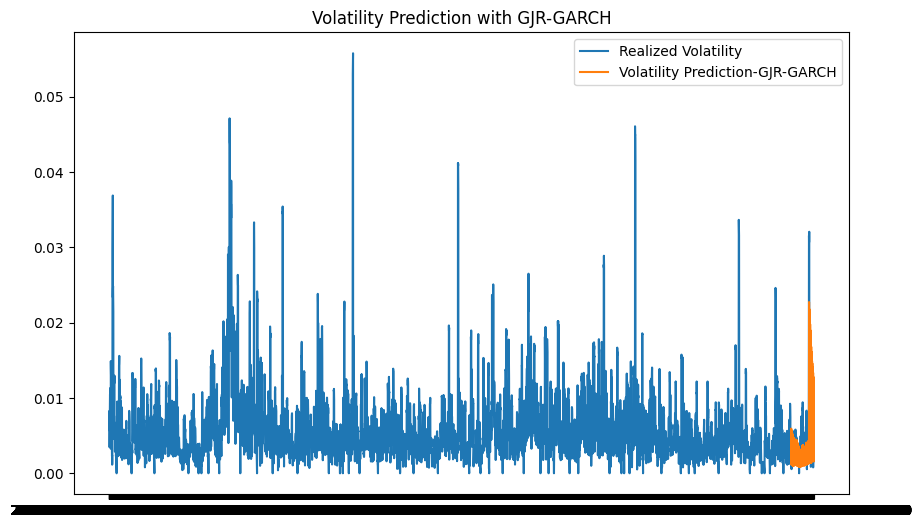

In [ ]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q

gjrgarch = arch_model(ret, mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())

forecast = gjrgarch.forecast(start=2001)
forecast_gjrgarch = forecast

rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()


# Volatility Prediction with EGARCH


---



The EGARCH model (Exponential Generalized Autoregressive Conditional Heteroskedasticity) addresses the leverage effect and allows for asymmetry in the impact of shocks on volatility. Unlike the GARCH model, the EGARCH model ensures that the conditional variance is always positive without imposing non-negativity constraints on the parameters. The logarithm of the variance is modeled, which can capture the asymmetry more effectively. This model includes parameters for the mean (set to zero here), the EGARCH terms (log-volatility persistence), and the asymmetric effect of shocks.

C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\mohni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmi

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                    AOS   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -7204.95
Distribution:                  Normal   AIC:                           14423.9
Method:            Maximum Likelihood   BIC:                           14472.7
                                        No. Observations:                 7835
Date:                Wed, Jun 05 2024   Df Residuals:                     7835
Time:                        15:43:47   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0353  1.860e-02      1.897  5.789e-02 

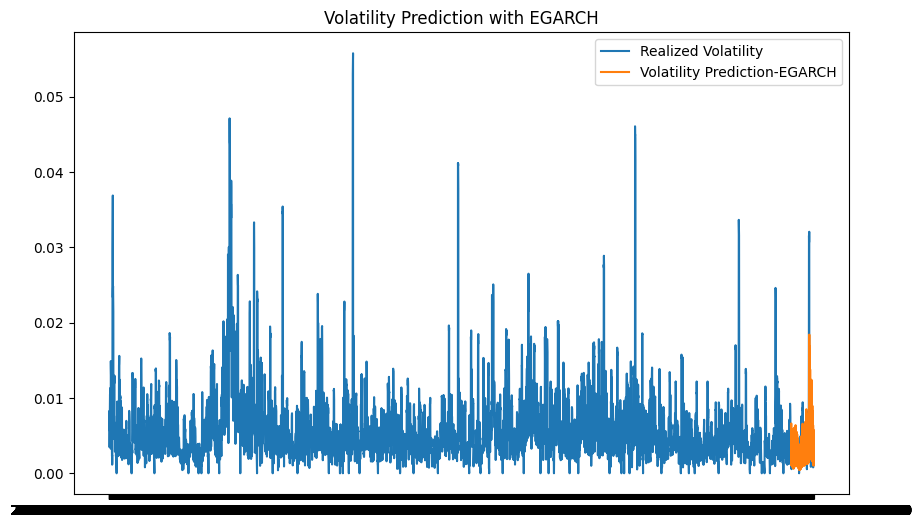

In [ ]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q

egarch = arch_model(ret, mean='zero', vol='EGARCH', p=best_param[0], q=best_param[1]).fit(disp='off')
print(egarch.summary())

forecast = egarch.forecast(start=2001)
forecast_egarch = forecast

rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_egarch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()